In [ ]:
#ディリクレ過程を使ったクラスタリングの基本プログラム
#2021年1月１３日から作成

In [ ]:
from __future__ import print_function
import argparse
import torch
from torch.utils import data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

%matplotlib inline
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np


from sklearn.manifold import TSNE
from random import random
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans

import math

import os
from PIL import Image
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable


import glob
import torchvision.transforms as transforms
import torchvision
from sklearn.model_selection import train_test_split
import pickle
import copy

In [ ]:
X_dim =1

In [356]:
N = 100
in_m = 1
in_w = 0
in_g = -0.5
s_m = 0.1
s_w = 0.1
s_g = 0.2
m_data = np.random.normal(in_m,s_m,N)
w_data = np.random.normal(in_w,s_w,2*N)
g_data = np.random.normal(in_g,s_g,3*N)
zero= np.zeros_like(m_data)
one = np.ones_like(w_data)
two = np.full_like(g_data,2)
iter =10
K = 2

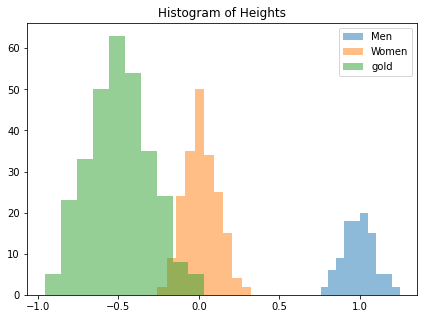

In [357]:
f, ax = plt.subplots(figsize = (7,5))
ax.set_title("Histogram of Heights")
ax.hist(m_data,alpha=.5,label = "Men")
ax.hist(w_data,alpha=.5,label = "Women")
ax.hist(g_data,alpha=.5,label = "gold")
ax.legend()

In [358]:
x_data = np.concatenate([m_data,w_data,g_data])
label_data = np.concatenate([zero,one,two])

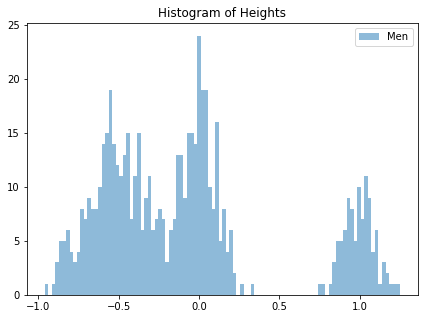

In [359]:
f, ax = plt.subplots(figsize = (7,5))
ax.set_title("Histogram of Heights")
ax.hist(x_data,alpha=.5,label = "Men",bins=100)
ax.legend()


In [360]:
random_label = np.random.permutation(np.arange(x_data.shape[0]))
x_p_data = x_data[random_label]
label_p_data =label_data[random_label]

In [361]:
x_p_data,label_p_data

(array([-2.68100630e-02,  1.00745735e-01,  1.64210226e-01, -4.40222323e-01,
         8.89504314e-02, -8.10706377e-01, -6.09716449e-01,  9.66427172e-01,
         1.21703675e+00, -1.51244281e-01, -3.17190585e-01,  2.74062900e-03,
        -5.95271979e-01,  7.77771378e-03, -3.46629979e-01, -6.33911556e-02,
        -4.24624550e-01, -4.20989606e-01,  9.24371159e-01, -5.44976191e-01,
        -5.71346205e-01,  9.17571367e-01, -8.56544321e-01,  9.83662025e-01,
        -6.36583462e-01, -6.62663661e-01, -6.10260042e-01, -4.43985690e-01,
         2.09233353e-01,  7.00670688e-02,  1.00636798e+00, -8.41608419e-02,
         4.40746920e-03,  6.62777541e-02, -7.38840329e-01, -1.75624529e-01,
        -2.08798761e-02, -2.40395817e-01,  9.69744934e-01,  9.93157328e-01,
         5.88139520e-04, -6.42912275e-01, -6.49050239e-01,  1.02211842e+00,
        -7.52661088e-01, -6.83913718e-01,  1.16689699e-01,  1.06154211e-01,
         8.78996656e-01,  1.09854120e+00,  8.36736240e-01, -5.78330728e-01,
        -6.8

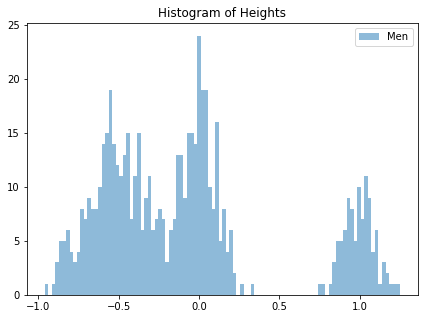

In [362]:
f, ax = plt.subplots(figsize = (7,5))
ax.set_title("Histogram of Heights")
ax.hist(x_p_data,alpha=.5,label = "Men",bins=100)
ax.legend()


In [363]:
X = x_p_data.reshape(x_p_data.shape[0],1)

In [364]:
def log_P_func(l_f,latent_data_f,pick_up_number_f,dirichlet_alpha_f,pre_nu_f,pre_beta_f,pre_mu_0_f,S_0_inv_f):

    cluster_data = latent_data_f[l_f]
    cluster_center = cluster_data.mean()
    n_prime = len(l_f)
    mu_c = (n_prime*cluster_center+pre_beta_f*pre_mu_0_f)/(n_prime+pre_beta_f)
    S_q_inv = S_0_inv_f + n_prime*np.cov(cluster_data,rowvar=0,bias=1) + n_prime*pre_beta_f*np.outer(cluster_center-pre_mu_0_f,cluster_center-pre_mu_0_f)/(n_prime + pre_beta_f)
    S_r_inv = S_q_inv + (n_prime + pre_beta_f)*np.outer(latent_data_f[pick_up_number_f]-mu_c,latent_data_f[pick_up_number_f]-mu_c)/(n_prime + pre_beta_f+1)
    data_dim = latent_data_f[pick_up_number_f].shape[0]
    n_total = latent_data_f.shape[0]
#    print("n_prime={}".format(n_prime))
#    print("cluster_center={}".format(cluster_center))
#    print("mu_c={}".format(mu_c))
#    print("S_q_inv={}".format(S_q_inv))
#    print("S_r_inv={}".format(S_r_inv))
#    print("data_dim={}".format(data_dim))
#    print("n_total={}".format(n_total))

#    return S_r_inv,S_q_inv
    return np.log(n_prime/(n_total-1+dirichlet_alpha_f))+0.5*data_dim*np.log((n_prime+pre_beta_f)/(n_prime+pre_beta_f+1)/math.pi) - 0.5*(pre_nu_f + n_prime +1)*np.log(S_r_inv)+0.5*(pre_nu_f + n_prime)*np.log(S_q_inv)+math.lgamma(0.5*(pre_nu_f+n_prime+1))-math.lgamma(0.5*(pre_nu_f+n_prime+1-data_dim))
#    return np.log(n_prime/(n_total-1+dirichlet_alpha_f))+0.5*data_dim*np.log((n_prime+pre_beta_f)/(n_prime+pre_beta_f+1)/math.pi) - 0.5*(pre_nu_f + n_prime +1)*np.log(np.linalg.det(S_r_inv))+0.5*(pre_nu_f + n_prime)*np.log(np.linalg.det(S_q_inv))+math.lgamma(pre_nu_f+n_prime+1)-math.lgamma(pre_nu_f+n_prime+1-data_dim)


def log_P_new_func(latent_data_f,pick_up_number_f,dirichlet_alpha_f,pre_nu_f,pre_beta_f,pre_mu_0_f,S_0_inv_f):

    picked_data = latent_data_f[pick_up_number_f]
    S_b_inv = S_0_inv_f + pre_beta_f*np.outer(picked_data-pre_mu_0_f,picked_data-pre_mu_0_f)/(pre_beta_f+1)
    data_dim = picked_data.shape[0]
    n_total = latent_data_f.shape[0]

#    print("S_0_inv={}".format(S_0_inv_f))
#    print("S_b_inv={}".format(S_b_inv))
#    print("data_dim={}".format(data_dim))
#    print("n_total={}".format(n_total))

#    return np.log(dirichlet_alpha_f/(n_total-1+dirichlet_alpha_f))+0.5*data_dim*np.log(pre_beta_f/(pre_beta_f+1)/math.pi) - 0.5*(pre_nu_f + 1)*np.log(np.linalg.det(S_b_inv))+0.5*pre_nu_f*np.log(np.linalg.det(S_0_inv_f))+math.lgamma(pre_nu_f+1)-math.lgamma(pre_nu_f+1-data_dim)
    return np.log(dirichlet_alpha_f/(n_total-1+dirichlet_alpha_f))+0.5*data_dim*np.log(pre_beta_f/(pre_beta_f+1)/math.pi) - 0.5*(pre_nu_f + 1)*np.log(S_b_inv)+0.5*pre_nu_f*np.log(S_0_inv_f)+math.lgamma(0.5*(pre_nu_f+1))-math.lgamma(0.5*(pre_nu_f+1-data_dim))

In [365]:
def sum_del_log_gamma(nu,n,dim):
    x=0
    for i in range(dim):
       x+= math.lgamma(0.5*(nu+n-i))-math.lgamma(0.5*(nu-i))
    return x

def log_P_total(list_list,latent_data,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv):

    cluster_number = len(list_list)
    data_dim = latent_data[0].shape[0]
    n_total = latent_data.shape[0]

    log_P = cluster_number*np.log(dirichlet_alpha)-math.lgamma(dirichlet_alpha+n_total)+ math.lgamma(dirichlet_alpha)
    for l in list_list:
        number_in_cluster = len(l)
        data_l = latent_data[l]
        data_l_av = data_l.mean(axis=0)
        S_q_inv = S_0_inv + number_in_cluster*np.cov(data_l,rowvar=0,bias=1)+ number_in_cluster*pre_beta*np.outer(data_l_av-pre_mu_0,data_l_av-pre_mu_0)/(number_in_cluster+pre_beta)
        log_P += math.lgamma(number_in_cluster) -0.5*(pre_nu+number_in_cluster)*np.log(S_q_inv) +0.5*pre_nu*np.log(S_0_inv)+sum_del_log_gamma(pre_nu,number_in_cluster,data_dim)+0.5*data_dim*(np.log(pre_beta/(number_in_cluster+pre_beta))-number_in_cluster*np.log(math.pi))
#        log_P += math.lgamma(number_in_cluster) -0.5*(pre_nu+number_in_cluster)*np.log(np.linalg.det(S_q_inv)) +0.5*pre_nu*np.log(np.linalg.det(S_0_inv))+sum_del_log_gamma(pre_nu,number_in_cluster,data_dim)+0.5*data_dim*(np.log(pre_beta/(number_in_cluster+pre_beta))-number_in_cluster*np.log(math.pi))

    return log_P

In [366]:
def softmax(a):
    # 一番大きい値を取得
    c = np.max(a)
    # 各要素から一番大きな値を引く（オーバーフロー対策）
    exp_a = np.exp(a - c)
    sum_exp_a = np.sum(exp_a)
    # 要素の値/全体の要素の合計
    y = exp_a / sum_exp_a
    return y

In [367]:
def cluster_prob(list_list,latent_data,pick_up_number,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv):

    for l in list_list:
        if pick_up_number in l:
            current_place = list_list.index(l)
            list_list[current_place].remove(pick_up_number)

    for x in list_list:
        if x == []:
#            disappearing_index = list_list.index(x)
            list_list.remove(x)

    log_P = np.empty(len(list_list)+1)
    for i, l in enumerate(list_list):
        log_P[i] = log_P_func(l,latent_data,pick_up_number,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv)

    log_P[len(list_list)] = log_P_new_func(latent_data,pick_up_number,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv)

    return softmax(log_P)

In [505]:
dirichlet_alpha_g = 1.
pre_nu_g =15.
pre_beta_g =0.3
pre_mu_0_g = 0.5
S_0_inv_g = 0.1

grouping = [list(range(X.shape[0]))]
grouping_temp = copy.deepcopy(grouping)

In [723]:
dirichlet_alpha_g = 1.
for pick_up_index in range(X.shape[0]):
#    print(np.arange(len(grouping_temp)+1))
#    print(cluster_prob(grouping_temp,X,pick_up_index,dirichlet_alpha_g,pre_nu_g,pre_beta_g,pre_mu_0_g,S_0_inv_g))
    probability = cluster_prob(grouping_temp,X,pick_up_index,dirichlet_alpha_g,pre_nu_g,pre_beta_g,pre_mu_0_g,S_0_inv_g)
    selected_cluster = np.random.choice(a=np.arange(len(grouping_temp)+1),size=1,p=probability).item()
    if selected_cluster == len(grouping_temp):
        grouping_temp.append([pick_up_index])
    else:
        grouping_temp[selected_cluster].append(pick_up_index)

In [724]:
len(grouping_temp)
#len(grouping_temp[1])

3

In [725]:
log_P_total(grouping_temp,X,dirichlet_alpha_g,pre_nu_g,pre_beta_g,pre_mu_0_g,S_0_inv_g)

array([[-317.02216735]])

In [726]:
X_0 = X[grouping_temp[0]]
X_0.mean(),X_0.std()

(-0.4895416072591196, 0.1969176222714639)

In [727]:
X_1 = X[grouping_temp[1]]
X_1.mean(),X_1.std()

(0.9938229388950937, 0.0973086043297542)

In [729]:
X_2 = X[grouping_temp[2]]
X_2.mean(),X_2.std()


(0.01710172892186148, 0.09838554462211817)

In [728]:
len(grouping_temp[0]),len(grouping_temp[1]),len(grouping_temp[2])

(305, 100, 195)

In [692]:
grouping_temp[0][0:10],label_p_data[0:10]

([3, 5, 6, 9, 10, 12, 14, 16, 17, 19],
 array([2., 1., 1., 2., 1., 2., 2., 0., 0., 1.]))

In [126]:
for i in grouping_temp[1]:
    print(X[i])

[1.12931233]
[1.04285735]
[0.88261541]
[1.04924732]
[0.8953836]
[1.0050834]
[0.90792492]
[0.88194107]
[0.78564884]
[1.0120798]
[1.01667148]
[1.01205861]
[1.00922529]
[1.15187228]
[1.13899947]
[1.03559532]
[1.14198641]
[0.94694388]
[0.89521651]
[0.891179]
[0.92238692]
[1.11343984]
[0.90345815]
[0.91681056]
[1.06305988]
[1.08400703]
[1.10366182]
[1.03696607]
[1.02439256]
[0.99228002]
[1.01126164]
[0.93281305]
[0.98332662]
[1.15255695]
[1.04974115]
[0.83747425]
[0.90662534]
[1.16870558]
[0.92283328]
[0.96575818]
[0.84859977]
[1.03583347]
[0.88934645]
[1.28156062]
[1.04161179]
[0.98743432]
[0.98427005]
[0.832564]
[0.90505039]
[1.04634933]
[1.03928149]
[1.07871263]
[1.22711612]
[1.19473503]
[1.11083476]
[0.9187888]
[0.94069455]
[1.00323238]
[1.03893104]
[1.0733756]
[1.03967666]
[0.92863064]
[1.02048102]
[1.0695718]
[1.17549656]
[0.96116483]
[0.87618985]
[1.0948134]
[0.81562199]
[0.96650658]
[0.96791873]
[0.99852379]
[0.87751473]
[0.97601808]
[1.11065995]
[0.88593706]
[0.79680502]
[1.0687578